              Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        Praskoveya         51     Moderate             1   
1              Brazil  Presidente Dutra         41         Good             1   
2               Italy   Priolo Gargallo         66     Moderate             1   
3              Poland         Przasnysz         34         Good             1   
4              France          Punaauia         22         Good             0   

  CO AQI Category  Energy_Recovery_in_GWh Ozone AQI Category  NO2 AQI Value  \
0            Good                      36               Good              0   
1            Good                       5               Good              1   
2            Good                      39               Good              2   
3            Good                      34               Good              0   
4            Good                      22               Good              0   

  NO2 AQI Category  PM2.5 AQI Value PM

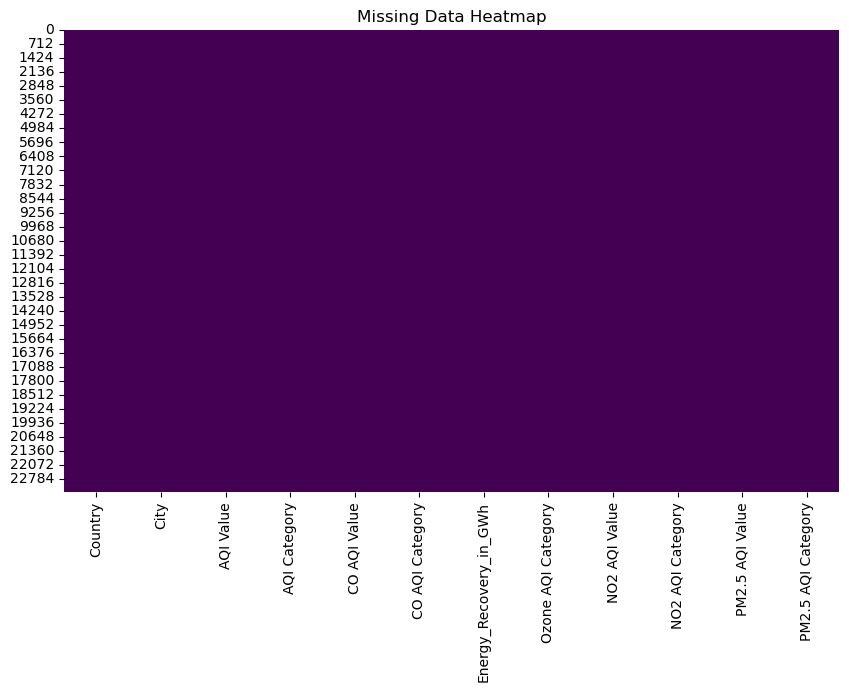

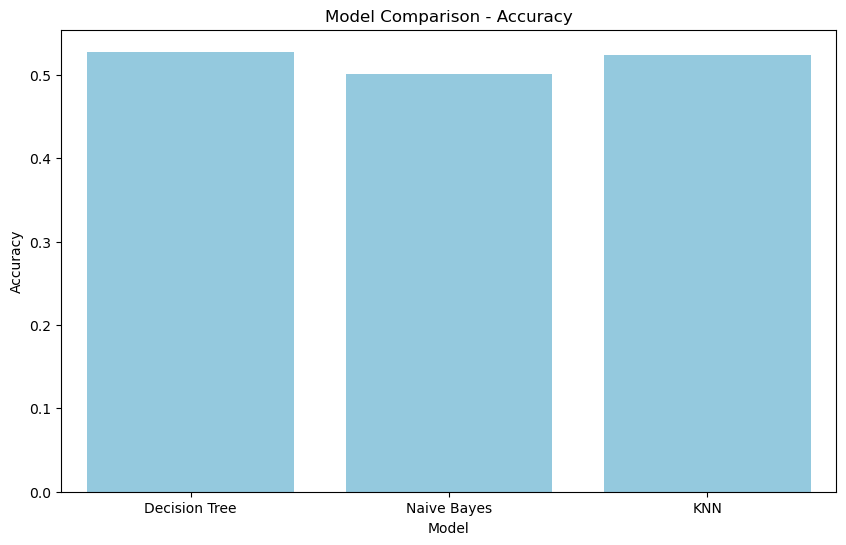

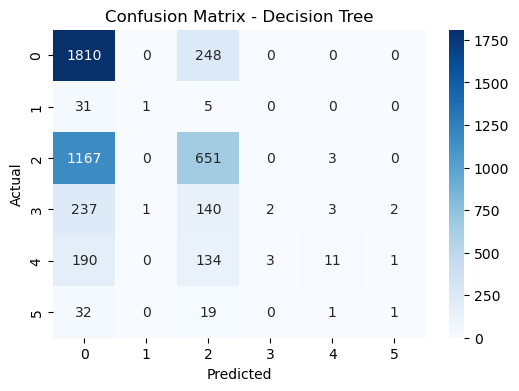

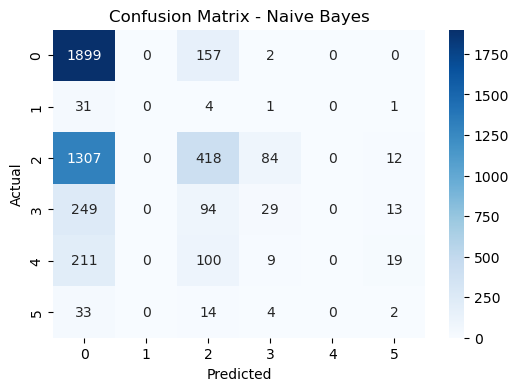

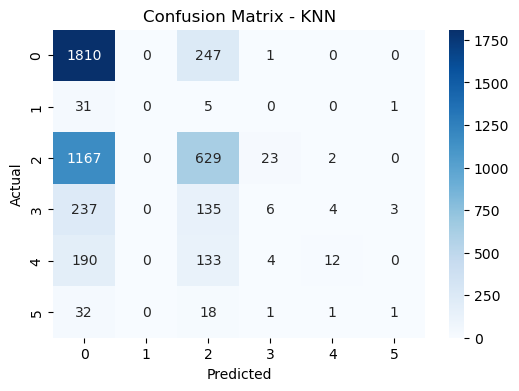

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


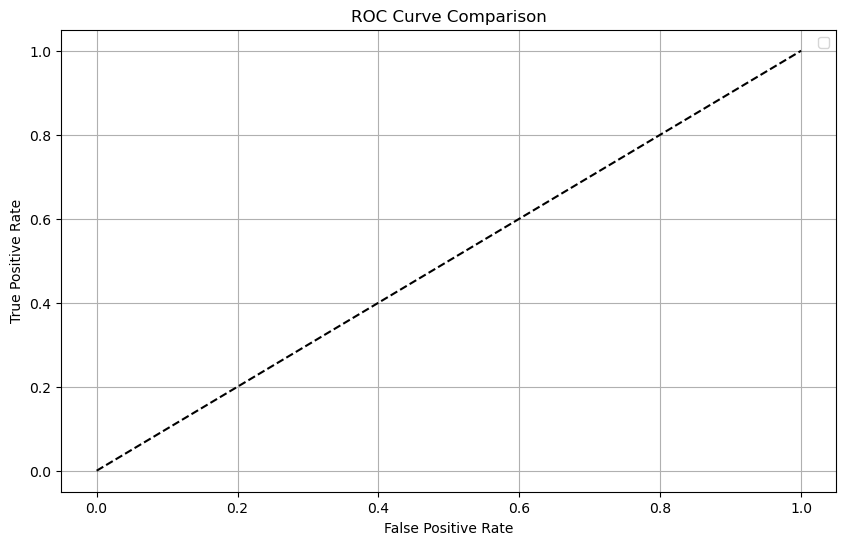


Model Evaluation Summary:
        Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
Decision Tree  0.527594   0.523694 0.527594  0.460815      NaN
  Naive Bayes  0.500320   0.448275 0.500320  0.421845      NaN
          KNN  0.523759   0.500024 0.523759  0.458265      NaN

Actionable Insights:

Model: Decision Tree
 - Accuracy: 0.53
 - Precision: 0.52
 - Recall: 0.53
 - F1 Score: 0.46
 - ROC AUC: Not available

Model: Naive Bayes
 - Accuracy: 0.50
 - Precision: 0.45
 - Recall: 0.50
 - F1 Score: 0.42
 - ROC AUC: Not available

Model: KNN
 - Accuracy: 0.52
 - Precision: 0.50
 - Recall: 0.52
 - F1 Score: 0.46
 - ROC AUC: Not available

Recommendation:
The best-performing model is **Decision Tree** with an Accuracy of 0.53 and F1 Score of 0.46.
This model provides great interpretability through decision rules.


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Load dataset
df = pd.read_csv("global air pollution dataset.csv")

# Basic cleaning
print(df.head())
print("Total missing values:", df.isnull().sum().sum())

df.replace("N/A", np.nan, inplace=True)  
df.fillna(0, inplace=True)
print("Any nulls after cleaning:", df.isnull().values.any())

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

# Impute missing values (if needed for any specific numeric columns)
if 'NO2 AQI Value' in df.columns:
    imputer = SimpleImputer(strategy='mean')
    df[['NO2 AQI Value']] = imputer.fit_transform(df[['NO2 AQI Value']])

# Normalize feature(s)
if 'NO2 AQI Value' in df.columns:
    scaler = StandardScaler()
    df[['NO2 AQI Value']] = scaler.fit_transform(df[['NO2 AQI Value']])

# Encode categorical features (if present)
for col in ['country', 'year']:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])

# Feature engineering (if source columns exist)
if 'energy_consumption' in df.columns and 'population' in df.columns:
    df['energy_consumption_per_capita'] = df['energy_consumption'] / df['population']
else:
    df['energy_consumption_per_capita'] = 0  # fallback

if 'pollution_index' in df.columns and 'year' in df.columns:
    df['yearly_pollution_trends'] = df.groupby('year')['pollution_index'].transform('mean')
else:
    df['yearly_pollution_trends'] = 0  # fallback

# Final feature and target selection
features = df[['NO2 AQI Value', 'energy_consumption_per_capita', 'yearly_pollution_trends']]
target = df['PM2.5 AQI Value']  # Ensure this exists and is categorical

# Convert PM2.5 AQI Value to categorical pollution severity levels FIRST
bins = [0, 50, 100, 150, 200, 300, np.inf]
labels = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
df['PM2.5 AQI Value'] = pd.cut(df['PM2.5 AQI Value'], bins=bins, labels=labels)

# Drop any remaining NaNs after binning
df.dropna(subset=['PM2.5 AQI Value'], inplace=True)

# Then select features and target
features = df[['NO2 AQI Value', 'energy_consumption_per_capita', 'yearly_pollution_trends']]
target = df['PM2.5 AQI Value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Model training and tuning
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_nb = gnb.predict(X_test)

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, {'n_neighbors': np.arange(1, 30)}, cv=5)
knn_cv.fit(X_train, y_train)
y_pred_knn = knn_cv.predict(X_test)

dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt, {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}, cv=5)
dt_cv.fit(X_train, y_train)
y_pred_dt = dt_cv.predict(X_test)

# Store tuned models
models = {
    "Decision Tree": DecisionTreeClassifier(**dt_cv.best_params_),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
}

# Evaluate models
results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1 Score": [], "ROC AUC": []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results["Model"].append(model_name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["Precision"].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    results["Recall"].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
    results["F1 Score"].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            results["ROC AUC"].append(roc_auc_score(y_test, y_proba))
        except:
            results["ROC AUC"].append(np.nan)
    else:
        results["ROC AUC"].append(np.nan)

# Results DataFrame
results_df = pd.DataFrame(results)

# Accuracy bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, color='skyblue')
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.show()

# Confusion matrices
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC Curves
plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
        except:
            continue

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("\nModel Evaluation Summary:")
print(results_df.to_string(index=False))

# Insights and recommendation
print("\nActionable Insights:")
for _, row in results_df.iterrows():
    print(f"\nModel: {row['Model']}")
    print(f" - Accuracy: {row['Accuracy']:.2f}")
    print(f" - Precision: {row['Precision']:.2f}")
    print(f" - Recall: {row['Recall']:.2f}")
    print(f" - F1 Score: {row['F1 Score']:.2f}")
    print(f" - ROC AUC: {row['ROC AUC']:.2f}" if not pd.isna(row['ROC AUC']) else " - ROC AUC: Not available")

# Best model recommendation
best_model_row = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]
print("\nRecommendation:")
print(f"The best-performing model is **{best_model_row['Model']}** with an Accuracy of {best_model_row['Accuracy']:.2f} "
      f"and F1 Score of {best_model_row['F1 Score']:.2f}.")

if best_model_row['Model'] == 'Decision Tree':
    print("This model provides great interpretability through decision rules.")
elif best_model_row['Model'] == 'Naive Bayes':
    print("Simple and fast, but may not capture complex relationships.")
elif best_model_row['Model'] == 'KNN':
    print("Effective but can be computationally expensive for large datasets.")
